In [1]:
from datasets.idda import IDDADataset
from datasets.idda import showIDDAsample
from models.deeplabv3 import deeplabv3_mobilenetv2
from torch.utils.data import DataLoader
import datasets.ss_transforms as sstr

In [2]:
train_transform=sstr.Compose([sstr.RandomResizedCrop((512,928),scale=(0.5,2)),sstr.ToTensor()])
#sstr.RandomResizedCrop((512,928),scale=(0.5,2))


In [3]:
iddaTrain=IDDADataset('data/idda',fileName='data/idda/train.txt',transform=train_transform)
print(f'Training set size: {iddaTrain.__len__()}')
iddaTestSame=IDDADataset('data/idda',fileName='data/idda/test_same_dom.txt')
print(f'Test set size for same domain: {iddaTestSame.__len__()}')
iddaTestDiff=IDDADataset('data/idda',fileName='data/idda/test_diff_dom.txt')
print(f'Test set size for diff domain: {iddaTestDiff.__len__()}')

Training set size: 600
Test set size for same domain: 120
Test set size for diff domain: 120


In [4]:
train_loader=DataLoader(iddaTrain,batch_size=10,shuffle=True)

In [5]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

c:\Users\ollob\anaconda3\envs\mldl23fl_6\lib\site-packages\torchvision\transforms\functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Feature batch shape: torch.Size([10, 3, 512, 928])
Labels batch shape: torch.Size([10, 512, 928])


In [6]:
print(iddaTrain[10])

(tensor([[[0.4471, 0.4471, 0.4471,  ..., 0.0588, 0.0627, 0.0510],
         [0.4471, 0.4471, 0.4471,  ..., 0.0627, 0.0627, 0.0745],
         [0.4510, 0.4510, 0.4510,  ..., 0.0627, 0.0706, 0.0745],
         ...,
         [0.7765, 0.7765, 0.7882,  ..., 0.8039, 0.8039, 0.8039],
         [0.7765, 0.7882, 0.7765,  ..., 0.8039, 0.8039, 0.8000],
         [0.7686, 0.7725, 0.7725,  ..., 0.7961, 0.7961, 0.8000]],

        [[0.5529, 0.5529, 0.5529,  ..., 0.0941, 0.0980, 0.0902],
         [0.5529, 0.5529, 0.5529,  ..., 0.1020, 0.1020, 0.1098],
         [0.5569, 0.5569, 0.5569,  ..., 0.1020, 0.1098, 0.1137],
         ...,
         [0.1137, 0.1412, 0.1137,  ..., 0.0000, 0.0000, 0.0000],
         [0.1373, 0.1059, 0.1020,  ..., 0.0000, 0.0000, 0.0000],
         [0.0510, 0.0627, 0.0627,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.6706, 0.6706, 0.6706,  ..., 0.0902, 0.0941, 0.0863],
         [0.6706, 0.6706, 0.6706,  ..., 0.0980, 0.0980, 0.1059],
         [0.6745, 0.6745, 0.6745,  ..., 0.0980, 0.1059, 0

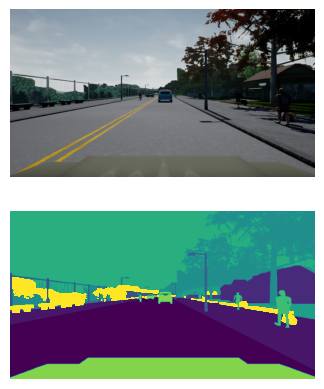

In [7]:
#showing a random sample
showIDDAsample(iddaTrain[140])

In [13]:
import client
import server
from models.deeplabv3 import deeplabv3_mobilenetv2
def createCentralizedServer(model,metrics,train_transform,test_transform,num_epochs,batch_size):
    iddaTrain=IDDADataset('data/idda',fileName='data/idda/train.txt',transform=train_transform,client_name='Centralized server')
    iddaTestSame=IDDADataset('data/idda',fileName='data/idda/test_same_dom.txt',transform=test_transform,client_name='IDDA same domain')
    iddaTestDiff=IDDADataset('data/idda',fileName='data/idda/test_diff_dom.txt',transform=test_transform,client_name='IDDA different domain')
    train_clients=[client.Client(dataset=iddaTrain,model=model,num_epochs=num_epochs,batch_size=batch_size)]
    test_clients=[client.Client(dataset=iddaTestDiff,model=model,test_client=True,num_epochs=num_epochs,batch_size=batch_size),client.Client(dataset=iddaTestSame,model=model,test_client=True,num_epochs=num_epochs,batch_size=batch_size)]
    return server.Server(train_clients=train_clients,test_clients=test_clients,model=model,metrics=metrics,num_rounds=1,clients_per_round=1)

In [14]:
#Parameters that MUST be changed
initialModel=deeplabv3_mobilenetv2(num_classes=16)
metrics='provaAcaso'
test_tr=sstr.Compose([sstr.RandomResizedCrop((512,928),scale=(0.5,2)),sstr.ToTensor()])
train_tr=sstr.Compose([sstr.RandomResizedCrop((512,928),scale=(0.5,2)),sstr.ToTensor()])
central=createCentralizedServer(initialModel,metrics,train_tr,test_tr,41,24)

In [15]:
import json

ROUND 1/1: Training 1 Clients...
CLIENT 1/1: Centralized server


NotImplementedError: 